<h1><center>Lab Régression Logistique avec IMDB dataset</center></h1>

In [304]:
# importation des librairies pour ce lab
import pandas as pd
import numpy as np 
from scipy import optimize
import re
from joblib import parallel_backend
import nltk
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, RocCurveDisplay
from sklearn.utils import shuffle

In [2]:
# lecture des données 
data_neg = pd.read_pickle('imdb_raw_neg.pickle')
data_pos = pd.read_pickle('imdb_raw_pos.pickle')

In [3]:
# conversion en Array pour manipulation
data_neg = np.array(data_neg)
data_neg = data_neg.reshape((len(data_neg),1))
data_pos = np.array(data_pos)
data_pos = data_pos.reshape((len(data_pos),1))

In [4]:
# fonction pour rajouter le vectuer y 
def structure(x_var: np.array, score: str):
    lenght = len(x_var)
    #x_var = x_var.rashape((lenght,1))
    if score == 'one':
        target = np.ones((lenght,1))
    else:
        target = np.zeros((lenght,1))
    return np.hstack((target, x_var))

negatives = structure(data_neg, score = 'zero' )
postiives = structure(data_pos, score = 'one') 
df = np.vstack((negatives, postiives)) 

## Preprocessing

In [5]:
def text_prepro(text): # fonction pour nettoyage du text
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [6]:
# stockage des données en dataframe 
df = pd.DataFrame(df, columns=['score', 'text']) 
df['text'] = df['text'].apply(text_prepro)
porter = PorterStemmer()

# fonctions pour tokenization à utiliser dans la pipline
def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()] 

nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Split et entrainement des modèles

In [250]:
# splitting les données en apprentissage et test (70 - 30)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['score'], test_size=0.3,
                                                    random_state=3)

In [117]:
# initialisation du modèle Tf-idf 
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=True,
                        preprocessor=None,
                        ngram_range=(1,2),
                        norm='l2',
                        stop_words=stop,
                        tokenizer=tokenizer )

# grille d'hypèreparamètre pour Gridsearchcv
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l2'],
               'clf__C': [1.0, 10.0, 100.0]}]


# creation des Piplines
# Regression logistique
lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(max_iter=3000, random_state=30 ))])

#Gridsearch avec la regression logistique
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=10,
                           n_jobs=1)

In [9]:
# entrainement du modèle logistique
lr_tfidf.fit(X_train, y_train)
print(lr_tfidf.score(X_train, y_train))
print(lr_tfidf.score(X_test, y_test))
print(confusion_matrix(y_test, lr_tfidf.predict(X_test)))

0.9731428571428572
0.8936
[[3349  439]
 [ 359 3353]]


In [13]:
# optimisation des hyperparamètres
with parallel_backend('threading', n_jobs=4):
    gs_lr_tfidf.fit(X_train, y_train)
# Résulat après la recherche des meilleurs paramètres
print(gs_lr_tfidf.best_score_)
print(gs_lr_tfidf.score(X_train, y_train))
print(gs_lr_tfidf.score(X_test, y_test))

In [15]:
# modèle Ridge
ridge_tfidf = Pipeline([('vect', tfidf),
                     ('clf', RidgeClassifier())])
ridge_tfidf.fit(X_train, y_train)
print(ridge_tfidf.score(X_train, y_train))
print(ridge_tfidf.score(X_test, y_test))
print(confusion_matrix(y_test, ridge_tfidf.predict(X_test)))

0.9997714285714285
0.9110666666666667
[[3403  385]
 [ 282 3430]]


In [16]:
# Optimisation du modèle Ridge
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__alpha': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__alpha': [1.0, 10.0, 100.0]}]

ridge_lr_tfidf = GridSearchCV(ridge_tfidf, param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=10,
                           n_jobs=1)
ridge_lr_tfidf.fit(X_train, y_train)
print(ridge_lr_tfidf.best_score_)
print(ridge_lr_tfidf.score(X_train, y_train))
print(ridge_lr_tfidf.score(X_test, y_test))

In [17]:
# Spécification d'un modèle passif aggressif
pa_tfidf = Pipeline([('vect', tfidf),
                     ('clf', PassiveAggressiveClassifier(max_iter=5000, 
                                                         early_stopping=True))])
pa_tfidf.fit(X_train, y_train)
print(pa_tfidf.score(X_train, y_train))
print(pa_tfidf.score(X_test, y_test))
print(confusion_matrix(y_test, pa_tfidf.predict(X_test)))

0.9913714285714286
0.9126666666666666
[[3427  361]
 [ 294 3418]]


## Utilisation d'un stack estimators

In [21]:
# comment on peut améliorer le modèle ? 
# j'ai testé plusieurs solutions notamment l'optimisation via la gridsearchcv mais elle prend un temps dingue
# pour gridsearch une régression logistique avec le tfidf c'est 1h30
# pour d'autres méthodes d'ensemble comme le bagging, randomforest, adaboost et gradienboosting c'est minimum 10h 
# l'approche qui optimise mieux mes résultat sous contrainte du temps et des ressources c'est le stacking
# avec un stack des meilleurs weak classifiers qui performe bien sur les données 
estimators = [
    ("Lr1", LogisticRegression(C=10, penalty='l2', max_iter=2000)),
    ("Lr2", LogisticRegression(C=10, penalty='l2', max_iter=2000)),
    ("Lr3", LogisticRegression(C=10, penalty='l2', max_iter=2000)),
    ("ridge", RidgeClassifier()),
    ("ridge1", RidgeClassifier()),
    ("ridge2", RidgeClassifier()),
    ('pa', PassiveAggressiveClassifier(max_iter=5000, early_stopping=True)),
    ('pa1', PassiveAggressiveClassifier(max_iter=5000, early_stopping=True)),
    ('pa2', PassiveAggressiveClassifier(max_iter=5000, early_stopping=True))
    ]

stack_tfidf = Pipeline([('vect', tfidf),
                        ('clf', StackingClassifier(estimators=estimators,
                                                   final_estimator= LogisticRegression(C=10, penalty='l2', max_iter=2000)
                                                   ))])
stack_tfidf.fit(tqdm(X_train), y_train)
print(stack_tfidf.score(X_train, y_train))
print(stack_tfidf.score(X_test, y_test))
#print(cross_validate(stack_tfidf, X_train, y_train, cv=3))
print(confusion_matrix(y_test, stack_tfidf.predict(X_test)))

100%|██████████████████████████████████████████████████████████████████████████| 17500/17500 [00:05<00:00, 3125.24it/s]


0.9993714285714286
0.9134666666666666
[[3441  347]
 [ 302 3410]]


## Rapport de classification et benchmark


In [22]:
# création de listes avec les résultats de tout les modèles utilisés

models = []
results_test = [] 
results_train = [] 
names = []
scoring = 'accuracy'

# on rajoute les modèles qu'on veut évaluer 
models.append(('reg_logi', lr_tfidf))
models.append(('Ridge_classifier',  ridge_tfidf))
models.append(('PassiveAggressive', pa_tfidf))
models.append(('stacking', stack_tfidf))

with parallel_backend('threading', n_jobs=2):
    for name, model in models:
        model.fit(X_train, y_train)
        score_train = model.score(X_train, y_train)
        score_test = model.score(X_test, y_test)
        results_test.append(score_test)
        results_train.append(score_train)
        names.append(name)
        repport_test = (name, score_test)
        repport_train = (name, score_train)
        data={'models': names, 
            'Accuracy_train': results_train, 
            'Accuracy_test': results_test}
        rep_tab = pd.DataFrame(data)



In [59]:
table = rep_tab

In [60]:
table.style.background_gradient('magma')

,Accuracy_train,Accuracy_test
models,,
reg_logi,0.973143,0.893600
Ridge_classifier,0.999771,0.911067
PassiveAggressive,0.990914,0.912133
stacking,0.999314,0.915467


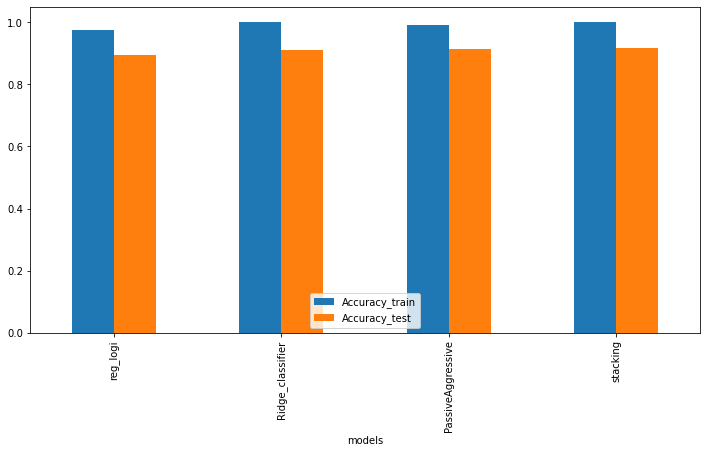

In [106]:
table.plot.bar(figsize=(12,6))
plt.legend(loc='lower center')

In [63]:
with parallel_backend('threading', n_jobs=4):
    for name, model in models:
        print(str(name))
        print(classification_report(y_test, model.predict(X_test)))

reg_logi
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89      3788
         1.0       0.88      0.90      0.89      3712

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500

Ridge_classifier
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      3788
         1.0       0.90      0.92      0.91      3712

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500

PassiveAggressive
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      3788
         1.0       0.91      0.92      0.91      3712

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0

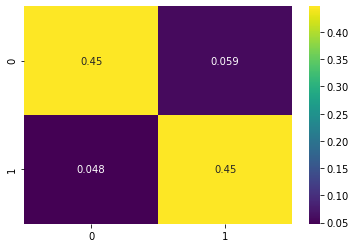

In [89]:
# matrice de confusion pour la régression logistique
sns.heatmap(confusion_matrix(y_test, lr_tfidf.predict(X_test))/
            np.sum(confusion_matrix(y_test, lr_tfidf.predict(X_test))),
            annot=True, cmap='viridis')


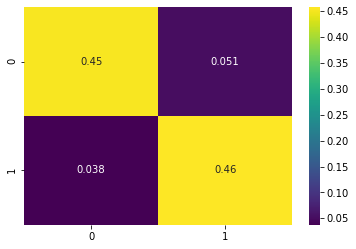

In [90]:
# matrice de confusion pour la régression ridge
sns.heatmap(confusion_matrix(y_test, ridge_tfidf.predict(X_test))/
            np.sum(confusion_matrix(y_test, ridge_tfidf.predict(X_test))),
            annot=True, cmap='viridis')

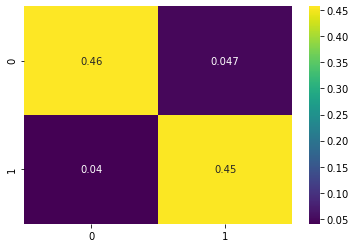

In [92]:
# matrice de confusion pour modèle passif-aggressif
sns.heatmap(confusion_matrix(y_test, pa_tfidf.predict(X_test))/
            np.sum(confusion_matrix(y_test, pa_tfidf.predict(X_test))),
            annot=True, cmap='viridis')

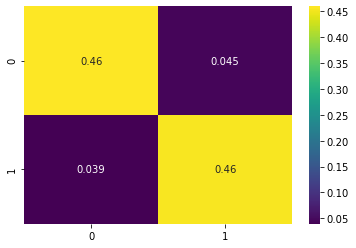

In [93]:
# matrice de confusion pour modèle pour le stacking
sns.heatmap(confusion_matrix(y_test, stack_tfidf.predict(X_test))/
            np.sum(confusion_matrix(y_test, stack_tfidf.predict(X_test))),
            annot=True, cmap='viridis')

## Recherche des 10 mots les plus déterminant dans la règle de décision du modèle
 

Que veut dire les 10 mots avec les plus déterminants dans le règle de décision du modèle ?

On sait que le modèle comporte un vecteur theta de paramètre qu'il va apprendre à partir des données, ce vecteur theta est composé d'un poids associers à chque feature, donc pour avoir les 10 features les plus impactants sont ceux qui sont associers au 10 poids plus grands en valeur absolue car après analyse les mots avec un sentiment negatif ont un poids negatif et inversement pour les mots positifs. 

Pour récupérer la liste des 10 mots, on commence par récupérer les coefs du modèle puis les classés (en valeur absolue) avec un argsort pour récupéré les indexs des 10 plus gros coef, après on cherche dans notre vocabulaire dans le vectorizer les mots dans les indexs en question.

In [107]:
# récupération des elements de la pipline de régression logistique
model = lr_tfidf[1]
tfidf = lr_tfidf[0]

In [312]:
# récupération des coef en valeur absolue
coef = abs(model.coef_)
# récupération du vocabulaire du tfidf
vocab = tfidf.vocabulary_

In [313]:
# sorting des coef en récupérant les indexs au lieux des coefs
idx = coef.argsort()
idxbest = idx[0][::-1] # inverstion du vecteur
# stockage des 10 plus gros coeffs
words10 = idxbest[:10]

words_indexs = []
for i in words10: # stockage des indexs en liste
    words_indexs.append(i)
    
words_10w = []
for i in words_indexs: # recherche des stocakges des mots dans la liste words_10
    words_10w.append(list(vocab.keys())[list(vocab.values()).index(i)])

In [314]:
# les 10 mots avec le plus gros impact sur la règle de décision du modèle
print(words_10w)

['bad', 'great', 'worst', 'awful', 'excellent', 'terrible', 'best', 'nothing', 'waste', 'boring']


In [241]:
# création d'une table résumant les résultats
table_des_mots = pd.DataFrame(data=(np.sort(abs(coef))[0][:10][::-1], words_10w), index=['Poids unitaire', 'Mots']).T
# calcule de la contribution globale dans la règle de décision du modèle
table_des_mots['Contribution globale'] = table_des_mots['Poids unitaire']/np.sum(abs(coef))
table_des_mots = table_des_mots.set_index('Mots') # règlage d'un nouveau index

In [249]:
print(table_des_mots)

          Poids unitaire Contribution globale
Mots                                         
bad          2.01854e-06          5.86587e-11
great         1.9764e-06          5.74342e-11
worst        1.43316e-06          4.16477e-11
awful        1.41437e-06          4.11015e-11
excellent    1.10263e-06          3.20426e-11
terrible     7.97062e-07          2.31626e-11
best         4.93358e-07           1.4337e-11
nothing      4.19203e-07           1.2182e-11
waste         4.0531e-07          1.17783e-11
boring       3.69757e-07          1.07451e-11


# Bonus

## Bayesian search


In [135]:
#Bayesian search pour améliorer la régression logistique
from skopt import BayesSearchCV
opt = BayesSearchCV(
    lr_tfidf,
    {
        'clf__C': [1, 10, 15],
        'clf__penalty': ['l2']
    },
    n_iter=32,
    cv=3,
    verbose=10
)


In [136]:
with parallel_backend('threading', n_jobs=4):
    opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  35.0s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.9s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  29.1s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  33.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  34.4s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.3s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  28.8s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  34.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  34.7s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.6s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  28.5s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  37.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  31.6s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.5s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  34.4s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  30.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  33.0s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.9s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  38.0s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  26.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... clf__C=1, clf__penalty=l2, score=0.877, total=  22.0s
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s


[CV] ........... clf__C=1, clf__penalty=l2, score=0.887, total=  20.1s
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.1s remaining:    0.0s


[CV] ........... clf__C=1, clf__penalty=l2, score=0.885, total=  22.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  41.0s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.9s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  36.8s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  36.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  32.2s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  40.0s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  25.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  34.3s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.2s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  28.7s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  33.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... clf__C=1, clf__penalty=l2, score=0.877, total=  22.0s
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s


[CV] ........... clf__C=1, clf__penalty=l2, score=0.887, total=  18.7s
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.7s remaining:    0.0s


[CV] ........... clf__C=1, clf__penalty=l2, score=0.885, total=  21.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  29.6s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.5s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  33.7s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  25.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  29.5s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.4s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  33.7s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  25.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  29.7s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.6s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  33.8s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  25.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... clf__C=1, clf__penalty=l2, score=0.877, total=  22.7s
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s remaining:    0.0s


[CV] ........... clf__C=1, clf__penalty=l2, score=0.887, total=  18.9s
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.6s remaining:    0.0s


[CV] ........... clf__C=1, clf__penalty=l2, score=0.885, total=  21.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  30.0s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  34.1s
[CV] clf__C=10, clf__penalty=l2 ......................................
[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  26.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  34.9s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.8s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  29.1s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  34.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  32.6s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.5s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  38.0s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  26.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  30.8s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.7s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  35.3s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  27.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  44.6s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.5s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  38.3s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  47.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  45.2s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.1s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  36.2s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  44.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  36.3s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.2s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  37.2s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  31.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  46.2s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.1s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  43.1s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  32.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  36.0s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.9s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  37.1s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  31.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... clf__C=1, clf__penalty=l2, score=0.877, total=  22.9s
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.8s remaining:    0.0s


[CV] ........... clf__C=1, clf__penalty=l2, score=0.887, total=  19.7s
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.6s remaining:    0.0s


[CV] ........... clf__C=1, clf__penalty=l2, score=0.885, total=  21.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... clf__C=1, clf__penalty=l2, score=0.877, total=  22.2s
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.1s remaining:    0.0s


[CV] ........... clf__C=1, clf__penalty=l2, score=0.887, total=  19.5s
[CV] clf__C=1, clf__penalty=l2 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.7s remaining:    0.0s


[CV] ........... clf__C=1, clf__penalty=l2, score=0.885, total=  24.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  36.3s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.2s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  30.6s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  35.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  30.5s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.4s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  35.9s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  26.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  36.9s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.8s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  29.9s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  40.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  34.6s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.5s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  38.0s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  29.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  37.6s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.5s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  30.4s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  37.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=10, clf__penalty=l2, score=0.892, total=  30.3s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.3s remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.904, total=  34.9s
[CV] clf__C=10, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=10, clf__penalty=l2, score=0.901, total=  26.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished
C:\Users\HP\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... clf__C=15, clf__penalty=l2, score=0.893, total=  35.7s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.6s remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.906, total=  29.7s
[CV] clf__C=15, clf__penalty=l2 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .......... clf__C=15, clf__penalty=l2, score=0.903, total=  35.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min finished


1.0
0.91
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      3788
         1.0       0.90      0.92      0.91      3712

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500



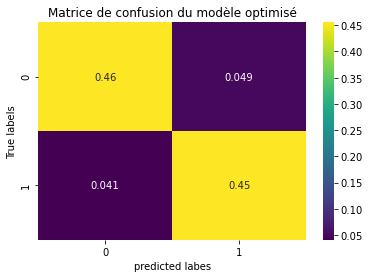

In [157]:
# résultat finaux de la recherche bayesienne 
print(opt.score(X_train, y_train))
print(np.round(opt.score(X_test, y_test),decimals=3 ))
#print(confusion_matrix(y_test, opt.predict(X_test)))
print(classification_report(y_test, opt.predict(X_test)))
sns.heatmap(confusion_matrix(y_test, opt.predict(X_test))/
            np.sum(confusion_matrix(y_test, opt.predict(X_test))),
            annot=True, cmap='viridis')
plt.xlabel('predicted labes')
plt.ylabel('True labels')
plt.title('Matrice de confusion du modèle optimisé')
plt.show()